# Data Cleaning and Feature Selection

## Imports

In [31]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns

## Data Cleaning

### 1. Outliers

Standard deviation method

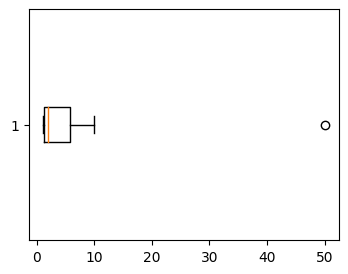

Mean =  5.944444444444445 
Std =  11.007432954459162
Outliers:
 [50]


In [32]:
data = [1, 2, 5, 6, 3, 1, 1, 7, 2, 2, 2, 3, 1, 1, 2, 8, 10, 50]

# construct boxplot to see if there are outliers:
plt.figure(figsize = (4,3))
plt.boxplot(data, vert = False)
plt.show()

# get the mean and standard deviation of the data:
mean = np.mean(data)
std = np.std(data)
print("Mean = ", mean, "\nStd = ", std)

# define threshold of z score and get the outliers
threshold = 3
outliers = []
for i in data:
    z = (i - mean)/ std
    if z > threshold:
        outliers.append(i)

print("Outliers:\n", outliers)


Interquartile range method

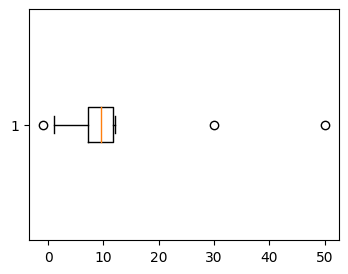

Quartile values using numpy:
Q1 =  7.25 
Q3 =  11.75
Quartile values using pandas:
Q1_pd =  7.25 
Q3_pd =  11.75

Boundaries:
lower =  0.5 
upper =  18.5

Outliers:  [-1 30 50]


In [33]:
# define data
data = np.array([-1, 1, 7, 8, 9, 10, 11, 12, 30, 50])

# boxplot
plt.figure(figsize = (4,3))
plt.boxplot(data, vert = False)
plt.show()

# get quartile values using numpy
Q1, Q3 = np.percentile(data, (25, 75))
print("Quartile values using numpy:")
print("Q1 = ", Q1, "\nQ3 = ", Q3)

# get quartile values using pandas
import pandas as pd
data_df = pd.DataFrame(data)
Q1_pd = data_df.quantile(0.25)
Q3_pd = data_df.quantile(0.75)
print("Quartile values using pandas:")
print("Q1_pd = ", Q1_pd[0], "\nQ3_pd = ", Q3_pd[0])

# calculate IQR and boundry values:
IQR = Q3 - Q1
lower_bound = Q1 - (1.5*IQR)
upper_bound = Q3 + (1.5*IQR)
print("\nBoundaries:")
print("lower = ", lower_bound, "\nupper = ", upper_bound)

# create conditions to isolate the outliers
outliers = data[(data < lower_bound)| (data> upper_bound)]
print("\nOutliers: ", outliers)

Automatic outlier detection

In [34]:
from sklearn.ensemble import IsolationForest
from sklearn.datasets import load_iris

# iris info
df,y = load_iris(return_X_y=True, as_frame=True)
df1 = df.copy()
df2 = df.copy()
data_info = load_iris()
features = data_info["feature_names"]
print(features)

# create a model and fit it to the data
model = IsolationForest(n_estimators=50, 
                        max_samples='auto', 
                        contamination=float(0.1),
                        max_features=1, 
                        verbose = 1)

model.fit(df[['sepal length (cm)']])

# add other columns scores and anomaly
df["scores"] = model.decision_function(df[["sepal length (cm)"]])
df["anomaly"] = model.predict(df[["sepal length (cm)"]])
#print(df.head(5))

# get the data points where anomaly = -1:
anomalies = df.loc[df["anomaly"]==-1]
print("Anomalies: \n", anomalies[:3])
outliers_count = len(anomalies)
print("\nOutlier Count: ", outliers_count)

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Anomalies: 
     sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
8                 4.4               2.9                1.4               0.2   
13                4.3               3.0                1.1               0.1   
38                4.4               3.0                1.3               0.2   

      scores  anomaly  
8  -0.013487       -1  
13 -0.147557       -1  
38 -0.013487       -1  

Outlier Count:  15


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
c:\Users\kruth\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


### 2. Missing Values

In [35]:
for i in range(6):
    df1.loc[0:i,'sepal length (cm)'] = np.NaN

for i in range(2,6):
    df1.loc[2:i,'petal length (cm)'] = np.NaN

df1.head(8)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,NaN,3.5,1.4,0.2
1,NaN,3.0,1.4,0.2
2,NaN,3.2,NaN,0.2
3,NaN,3.1,NaN,0.2
4,NaN,3.6,NaN,0.2
5,NaN,3.9,NaN,0.4
6,4.6,3.4,1.4,0.3
7,5.0,3.4,1.5,0.2


Iterative Imputation:
- The approach is called MICE - Multivariate Imputation by Chained Equations.
- each feature is modelled as a function of the other features.
- this is performed in a round-robin fashion
- first all the missing values in the dataset are set to some stat value.
- then, the 1st col with missing value is considered as the target variable and rest and used for training the model
- the model by default is Bayesian Ridge Regression which performs regression task to find the missing values.
- the same process is repeated for all the columns with missing values.
- this iterative process is repeated for a number of times (default is 10).
- the algorithm converges after these iterations complete and the missing values and estimated iteratively.

All imputations:

In [36]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer

s_chi2 = SimpleImputer( missing_values=np.NaN, strategy="mean")
i = IterativeImputer(imputation_order='ascending')
k = KNNImputer(n_neighbors=3)

s_chi2.fit(df1)
i.fit(df1)
k.fit(df1)

df_si = pd.DataFrame(s_chi2.transform(df1), columns=features)
df_ii = pd.DataFrame(i.transform(df1), columns=features)
df_ki = pd.DataFrame(k.transform(df1), columns=features)

In [37]:
df1.head(7)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,NaN,3.5,1.4,0.2
1,NaN,3.0,1.4,0.2
2,NaN,3.2,NaN,0.2
3,NaN,3.1,NaN,0.2
4,NaN,3.6,NaN,0.2
5,NaN,3.9,NaN,0.4
6,4.6,3.4,1.4,0.3


In [38]:
df2.head(7)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
5,5.4,3.9,1.7,0.4
6,4.6,3.4,1.4,0.3


In [39]:
df_si.head(7)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.880556,3.5,1.400000,0.2
1,5.880556,3.0,1.400000,0.2
2,5.880556,3.2,3.820548,0.2
3,5.880556,3.1,3.820548,0.2
4,5.880556,3.6,3.820548,0.2
5,5.880556,3.9,3.820548,0.4
6,4.600000,3.4,1.400000,0.3


In [40]:
df_ii.head(7)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.014158,3.5,1.400000,0.2
1,4.694441,3.0,1.400000,0.2
2,4.936532,3.2,1.564903,0.2
3,4.897632,3.1,1.601065,0.2
4,5.092129,3.6,1.420255,0.2
5,5.401864,3.9,1.740926,0.4
6,4.600000,3.4,1.400000,0.3


In [41]:
df_ki.head(7)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.300000,3.5,1.400000,0.2
1,4.533333,3.0,1.400000,0.2
2,4.700000,3.2,1.366667,0.2
3,4.900000,3.1,1.433333,0.2
4,5.000000,3.6,1.233333,0.2
5,5.400000,3.9,1.633333,0.4
6,4.600000,3.4,1.400000,0.3


### Feature Selection

1. Intrinsic Methods - L1 and L2 regularization, Tree based methods, Neural Networks
2. Wrapper Methods - Forward, Backward, Recursive Feature Elimination
3. Filter Methods - Correlations (Pearson, Spearman), ANOVA, Kendall's Tau, Chi-Square, Mutual Information

Filter Methods Categorization:

1. Numerical Input, Numerical Output
    - Pearson's Correlation Coefficient (linear): -1 to 1 correlation coefficient
    - Spearman's Rank Correlation Coefficient (nonlinear): monotonically increasing or decreasing relationship
    - Kendall's Rank Correlation Coefficient (nonlinear): measures strength and direction of variables

2. Numerical Input, Categorical Output
    - ANOVA f-test: comparing the means of 2 or more groups and checking if they are similar or not. 
    - Kendall's Tau: measures strength and direction of variables

3. Categorical Input, Numerical Output
    - ANOVA f-test: comparing the means of 2 or more groups and checking if they are similar or not. 
    - Kendall's Tau: measures strength and direction of variables

4. Categorical Input, Categorical Output
    - Chi-Square: comparing the observed frequencies with the expected frequencies of categorical variables to check if they are similar or not.
    - Mutual Information: measures the amount of information obtained about one variable through observing the other variable.

Note: Mutual Information can be used for all types of input and output variables.

In [42]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif, f_regression, mutual_info_regression

s_chi2 = SelectKBest(score_func=chi2, k=2)
s_chi2.fit(df2, y)
df2_scores = pd.DataFrame(s_chi2.scores_)
print(df2_scores)

            0
0   10.817821
1    3.710728
2  116.312613
3   67.048360


In [43]:
s_f_classif = SelectKBest(score_func=f_classif, k=2)
s_f_classif.fit(df2, y)
df2_scores = pd.DataFrame(s_f_classif.scores_)
print(df2_scores)

             0
0   119.264502
1    49.160040
2  1180.161182
3   960.007147


In [44]:
s_mutual_info_classif = SelectKBest(score_func=mutual_info_classif, k=2)
s_mutual_info_classif.fit(df2, y)
df2_scores = pd.DataFrame(s_mutual_info_classif.scores_)
print(df2_scores)
f_mic = s_mutual_info_classif.transform(df2)

          0
0  0.503158
1  0.251047
2  0.991055
3  0.992513


RFE

In [45]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=2)
res = rfe.fit_transform(df2, y)
#print(res)

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

model = DecisionTreeClassifier()
model.fit(res,y)

scores = cross_val_score(model, res, y, cv = 5, n_jobs=-1)
print(np.mean(scores))

0.9533333333333334
